# Diffusivity tensor for any resolution

In [1]:
import numpy as np
import xarray as xr
from funcs import *
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm

In [2]:
Lcoarse = 25e3

In [3]:
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km')

In [4]:
list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']
list_trac2 = ['Tr01', 'Tr02', 'Tr03', 'Tr04', 'Tr05', 
            'Tr06', 'Tr07', 'Tr08', 'Tr09', 'Tr10', 
            'Tr11', 'Tr12', 'Tr13', 'Tr14', 'Tr15', 
            'Tr16', 'Tr17', 'Tr18', 'Tr19', 'Tr20']

In [5]:
Trac_coarse_2D = Trac_coarse.mean(['XCcoarse'])

In [6]:
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse_2D, list_trac)
[dCdx, dCdy, dCdz] = get_grad_arrays(Trac_coarse_2D, list_trac)

In [7]:
KvCz = get_diff_flux_arrays(Trac_coarse_2D, list_trac2)

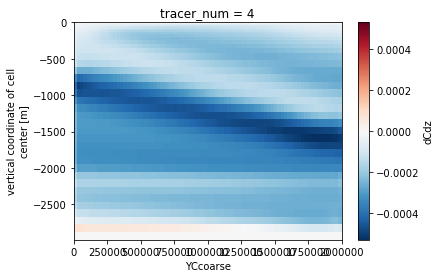

In [9]:
dCdz.isel(tracer_num=3).plot()

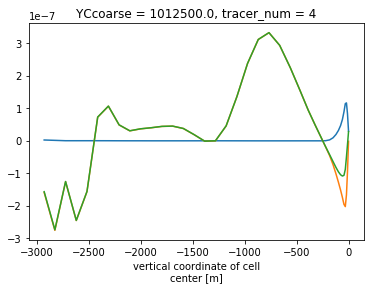

In [10]:
(KvCz/25e6).isel(tracer_num=3).sel(YCcoarse=1000e3, method='nearest').plot()
(WpCp).isel(tracer_num=3).sel(YCcoarse=1000e3, method='nearest').plot()
(WpCp+KvCz/25e6).isel(tracer_num=3).sel(YCcoarse=1000e3, method='nearest').plot()


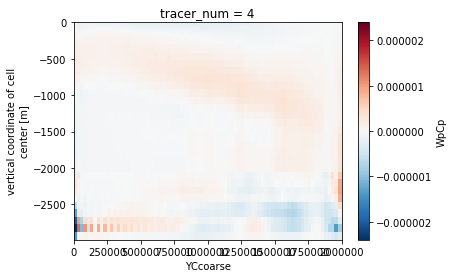

In [11]:
WpCp.isel(tracer_num=3).plot()

In [12]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

Ktensor_fast = xr.apply_ufunc(calc_tensor_2D, 
                       VpCp.sel(tracer_num=slice(1,19,2)),
                       WpCp.sel(tracer_num=slice(1,19,2)) + KvCz.sel(tracer_num=slice(1,19,2))/(5e3*5e3),
                       dCdy.sel(tracer_num=slice(1,19,2)),
                       dCdz.sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':2,'j':2})

Ktensor_fast.load() # need to load because we will take transpose and a

CPU times: user 586 ms, sys: 4.86 ms, total: 591 ms
Wall time: 732 ms


In [14]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

Ktensor_slow = xr.apply_ufunc(calc_tensor_2D, 
                       VpCp.sel(tracer_num=slice(2,20,2)),
                       WpCp.sel(tracer_num=slice(2,20,2)) + KvCz.sel(tracer_num=slice(2,20,2))/(5e3*5e3),
                       dCdy.sel(tracer_num=slice(2,20,2)),
                       dCdz.sel(tracer_num=slice(2,20,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':2,'j':2})

Ktensor_slow.load() # need to load because we will take transpose and a

CPU times: user 650 ms, sys: 0 ns, total: 650 ms
Wall time: 648 ms


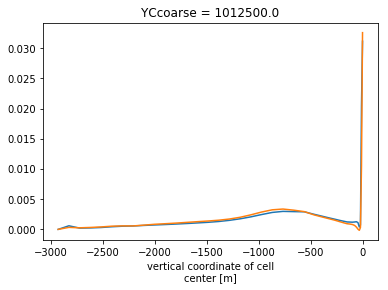

In [16]:
(Ktensor_slow).isel(i=1, j=1).sel(YCcoarse=1000e3, method='nearest').plot()
(Ktensor_fast).isel(i=1, j=1).sel(YCcoarse=1000e3, method='nearest').plot()

In [17]:
lam1 = 1/31104000.
lam2 = 1/186624000.

Ktensor_corr = (lam2*Ktensor_fast - lam1*Ktensor_slow)/(lam2 - lam1)

In [18]:
Ktensor_corrT = Ktensor_corr.transpose('Z','YCcoarse','j','i')

ST = 0.5*(Ktensor_corr.data + Ktensor_corrT.data)
AT = 0.5*(Ktensor_corr.data - Ktensor_corrT.data)

ST = xr.DataArray(ST, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)
AT = xr.DataArray(AT, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)

In [19]:
# make sure the eigen values are arranged by magnitude (instead of the default arrangement)
def eigen(A):
    eigenValues, eigenVectors = eigh(A)
    idx = np.argsort(np.abs(eigenValues))
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

In [20]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsST, eigvecsST = xr.apply_ufunc(eigen, ST, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

In [21]:
diff_tensor = xr.Dataset()
diff_tensor['Kfast'] = Ktensor_fast
diff_tensor['Kslow'] = Ktensor_slow
diff_tensor['Kcorr'] = Ktensor_corr
diff_tensor['ST'] = ST
diff_tensor['AT'] = AT
diff_tensor['eigvalsST'] = np.real(eigvalsST)
diff_tensor['eigvecsST'] = eigvecsST

In [22]:
diff_tensor.to_netcdf('./outputs_ncfiles/diff_tensor_with_diff_2D_'+str(int(Lcoarse//1e3))+'km.nc')

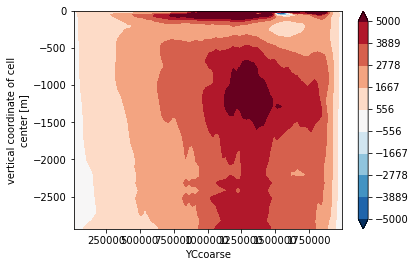

In [23]:
eigvalsST.isel(ii=1).plot.contourf(levels=10, vmin=-5000)

# Scrap notes

In [16]:
Xcoarse = Trac_coarse.XCcoarse.data
Ycoarse = Trac_coarse.YCcoarse.data
Z = Trac_coarse.Z.data

Ypcol = np.append(Ycoarse, Ycoarse[-1]+Lcoarse)-Lcoarse/2
Xpcol = np.append(Xcoarse, Xcoarse[-1]+Lcoarse)-Lcoarse/2
Zpcol = np.append(Z, Z[-1])

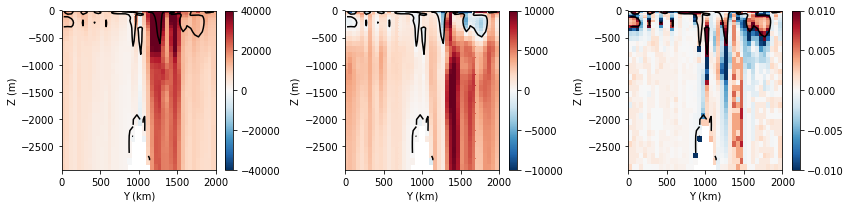

In [21]:
fig, ax = plt.subplots(1,3, figsize=(12,3))

im = ax[0].pcolormesh(Xpcol/1e3, Z,diff_tensor.eigvalsST.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=1000e3, method='nearest').isel(ii=2), 
                vmin=-4e4, vmax=4e4, cmap='RdBu_r', rasterized=True)
#ax[0].pcolor(Xpcol/1e3, Z, T_coarse.hFacCcoarse.where(Trac_coarse.YCcoarse>=1900e3).sel(YCcoarse=1000e3, method='nearest'),
#              hatch='x', alpha=0)
ax[0].contour(Xcoarse/1e3, Z,diff_tensor.eigvalsST.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=1000e3, method='nearest').isel(ii=1), 
             levels=[0.], colors='k')
ax[0].set_xlabel('Y (km)')
ax[0].set_ylabel('Z (m)')

fig.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(Xpcol/1e3, Z,diff_tensor.eigvalsST.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=1000e3, method='nearest').isel(ii=1), 
                vmin=-1e4, vmax=1e4, cmap='RdBu_r', rasterized=True)
ax[1].contour(Xcoarse/1e3, Z,diff_tensor.eigvalsST.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=1000e3, method='nearest').isel(ii=1), 
             levels=[0], colors='k')
#ax[1].pcolor(Xpcol/1e3, Z, T_coarse.hFacCcoarse.where(Trac_coarse.YCcoarse>=1900e3).sel(YCcoarse=1000e3, method='nearest'),
#              hatch='x', alpha=0)
ax[1].set_xlabel('Y (km)')
ax[1].set_ylabel('Z (m)')
fig.colorbar(im, ax=ax[1])


im = ax[2].pcolormesh(Xpcol/1e3, Z,diff_tensor.eigvalsST.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=1000e3, method='nearest').isel(ii=0), 
                vmin=-1e-2, vmax=1e-2, cmap='RdBu_r', rasterized=True)
ax[2].contour(Xcoarse/1e3, Z,diff_tensor.eigvalsST.where(Trac_coarse.hFacCcoarse==1.).sel(YCcoarse=1000e3, method='nearest').isel(ii=1), 
             levels=[0.], colors='k')
#ax[2].pcolor(Xpcol/1e3, Z, T_coarse.hFacCcoarse.where(Trac_coarse.YCcoarse>=1900e3).sel(YCcoarse=1000e3, method='nearest'),
#              hatch='x', alpha=0)
ax[2].set_xlabel('Y (km)')
ax[2].set_ylabel('Z (m)')
fig.colorbar(im, ax=ax[2])

plt.tight_layout()

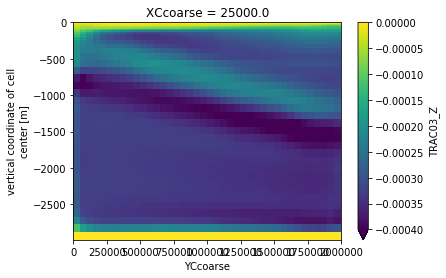

In [12]:
Trac_coarse.TRAC03_Z.sel(XCcoarse=0, method='nearest').plot(vmin=-4e-4)

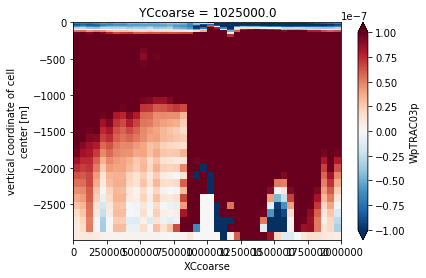

In [21]:
Trac_coarse.WpTRAC03p.sel(YCcoarse=1000e3, method='nearest').plot(vmin=-1e-7)

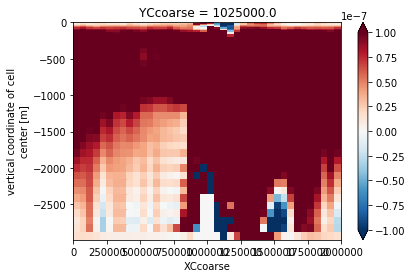

In [23]:
(Trac_coarse.DFrITr03/(5e3*5e3) + Trac_coarse.WpTRAC03p).sel(YCcoarse=1000e3, method='nearest').plot(vmin=-1e-7)

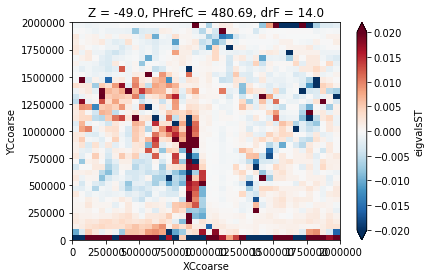

In [24]:
diff_tensor.eigvalsST.sel(Z=-50, method='nearest').isel(ii=0).plot(vmin=-2e-2)